In [58]:
# === Essential Imports ===
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# === Dataset Paths ===
DATA_DIR = './dataset_2'
TEST_DIR = './test'

# === Hyperparameters ===
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
SEED = 123


In [60]:
# === Load raw dataset (only for class name extraction)
raw_for_classnames = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",       # 🔑 One-hot encoding
    color_mode="grayscale"
)

# === Extract class names BEFORE preprocessing
class_names = raw_for_classnames.class_names
NUM_CLASSES = len(class_names)
print("✅ Classes:", class_names)

# === Reload full train/val/test sets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    color_mode="grayscale"
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    color_mode="grayscale"
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    color_mode="grayscale"
)

# === Preprocess: convert grayscale → RGB and normalize
def preprocess_grayscale(ds):
    return ds.map(lambda x, y: (preprocess_input(tf.image.grayscale_to_rgb(x)), y), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

train_ds = preprocess_grayscale(train_ds)
val_ds = preprocess_grayscale(val_ds)
test_ds = preprocess_grayscale(test_ds)


Found 480 files belonging to 4 classes.
Using 384 files for training.
✅ Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Found 480 files belonging to 4 classes.
Using 384 files for training.
Found 480 files belonging to 4 classes.
Using 96 files for validation.
Found 480 files belonging to 4 classes.


In [61]:
# === Load Base Model (EfficientNetB0 pretrained on ImageNet) ===
# EfficientNet expects 3-channel input, which we ensured in preprocessing
base_model = EfficientNetB0(
    include_top=False,
    input_shape=IMG_SIZE + (3,),
    weights='imagenet'
)
base_model.trainable = False  # ✅ Freeze for stability

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=output)



In [62]:
# === Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)



In [63]:
# === Train the model ===
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight_dict,   # ⚖️ Handles class imbalance
    callbacks=[early_stop]            # ⏹ Early stopping on val_loss
)


Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 789ms/step - accuracy: 0.2125 - loss: 1.4977 - val_accuracy: 0.1979 - val_loss: 1.4782
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 574ms/step - accuracy: 0.2247 - loss: 1.5114 - val_accuracy: 0.2292 - val_loss: 1.4188
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 555ms/step - accuracy: 0.2600 - loss: 1.4655 - val_accuracy: 0.2812 - val_loss: 1.3673
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 548ms/step - accuracy: 0.3361 - loss: 1.3700 - val_accuracy: 0.3854 - val_loss: 1.3212
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 547ms/step - accuracy: 0.3273 - loss: 1.3602 - val_accuracy: 0.4479 - val_loss: 1.2781
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 570ms/step - accuracy: 0.3703 - loss: 1.3027 - val_accuracy: 0.5104 - val_loss: 1.2376
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 547ms/step - accuracy: 0.3820 - loss: 1.2838 - val_accuracy: 0.5417 - val_loss: 1.2001
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 580ms/step - accuracy: 0.4927 - loss: 1.2190 - val_accuracy: 0

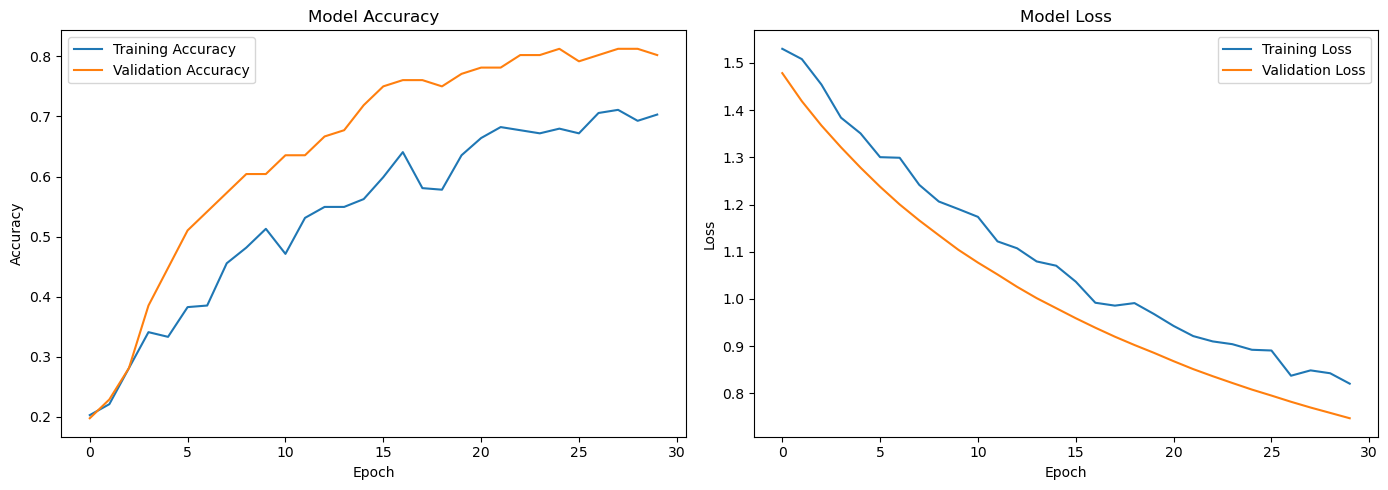

In [65]:
# === Plot training history ===
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 386ms/step
✅ Classification Report:
              precision    recall  f1-score   support

      glioma       0.24      0.26      0.25       120
  meningioma       0.27      0.19      0.22       120
     notumor       0.26      0.27      0.26       120
   pituitary       0.24      0.28      0.26       120

    accuracy                           0.25       480
   macro avg       0.25      0.25      0.25       480
weighted avg       0.25      0.25      0.25       480



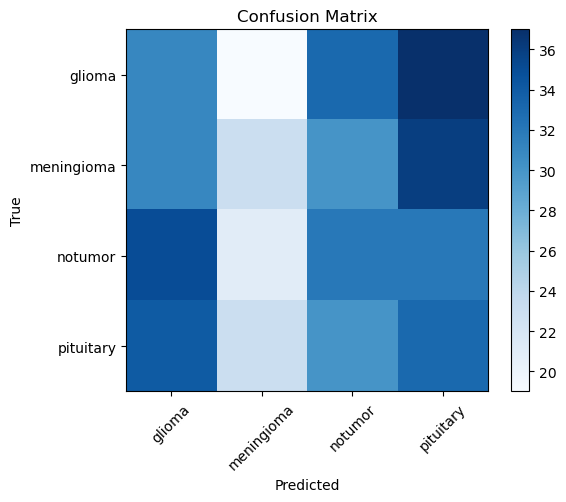

In [67]:
# === Predict on test set ===
y_true = np.concatenate([y.numpy() for x, y in test_ds])
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# === Convert one-hot labels to class indices
y_true = np.argmax(y_true, axis=1)

# === Evaluation Report
print("✅ Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# === Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=range(NUM_CLASSES), labels=class_names, rotation=45)
plt.yticks(ticks=range(NUM_CLASSES), labels=class_names)
plt.colorbar()
plt.tight_layout()
plt.show()


In [57]:
# === Save the trained model ===
model.save("efficientnet_base.h5")
print("✅ Model saved as efficientnet_base.h5")


✅ Model saved as efficientnet_base.h5
